# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in Grunnill et al. (2024). MetaCast's main feature is broad*CAST*ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a *META*population model.

This notebook uses a disease X SEIHR (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at 10% prevalence: Multinomial seeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


# 1. Age-Structured: Single Dimension/Axis disease X model.

Import MetaCast's main class MetaCaster.

In [1]:
from metacast import MetaCaster

## 1.1 MetaCaster setup
### 1.1.1 Define subpopulation model.

This is the function that is your subpopulation model that MetaCaster will broadcast across the metapopulation generated by your scaffold (see 1.2).
The arguments are required

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time.
    y_deltas : numpy.Array
        The derivatives of y at this time.
    parameters : dict {str:Number or callable}
        A dictionary of parameter values.
    states_index : dict {str:int}

    subpop_suffix : str

    foi : float
        Force of infection experienced be susceptible hosts in this subpopulation.

    Returns
    -------
    y_deltas : numpy.Array
        y_deltas with derivatives of variables in disease X's subpopulation model added to.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery
    y_deltas[-1] += hospitalisation

    return y_deltas

### 1.1.2 Define metapopulation scaffold.

In this first we are assuming structure comes from just the risk of hospitalisation (low and high). Simulations are going to be over 90 days. Therefore, we will assume no flows of population between subpopulations. As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our scaffold (a list/tuple of unique strings is also acceptable. **Note** if dealing with a multidimensional metapopulation the scaffold would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define model attributes

In [4]:
model_attributes = {'states': ['S', 'E', 'I', 'H', 'R'],
                    'infected_states': ['E', 'I'],
                    'infectious_states': ['I'],
                    'symptomatic_states': ['I'],
                    'observed_states': ['H','H_cumulative'],
                    'universal_params': ['sigma', 'gamma', 'eta'],
                    'subpop_params': ['p']}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(scaffold=risk_groups, model_attributes=model_attributes, subpop_model=subpop_model)

# 1.2 Running model
## 1.2.1 Setting population

In [6]:
import numpy as np
metapop_model.num_states

12

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.num_states)
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
hig_risk_prob_of_hospital = 0.3
low_risk_prob_of_hospital = 0.01
hospitalisation_probs = {'p_[high]': hig_risk_prob_of_hospital, 'p_[low]': low_risk_prob_of_hospital}
transmission_no_intervention = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: transmission_no_intervention for subpop_suffix in metapop_model.subpop_suffixes}
subpopulation_interactions = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: subpopulation_interactions
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.3,
 'p_[low]': 0.01,
 'beta_[low]': 2.857142857142857e-07,
 'beta_[high]': 2.857142857142857e-07,
 'rho_[low]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[high]_[high]': 1}

### 1.2.3 Run metapopulation model

In [11]:
#set time
t = np.arange(0,91,1)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [12]:
results_1 = metapop_model.integrate(y,t)

In [13]:
results_1

low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

             high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

   observed_states               
                 H H_cumulative  
0         0.000000     0.000000  
1         0.001276     0.001407  
2         0.002509     0.003017  
3         0.003919     0.005066  
4         0.005593     0.007687  
..             ...          ...  
86       18.655788    62.633214  
87       20.301457    68.172298  
88       22.091637    74.199277  
89       24.038897    80.756863  
90       26.156877    87.891455  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

In [14]:
import seaborn as sns

In [15]:
results_1['t'] = t
results_1_melted = results_1.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_1_melted

,t,Subpopulation,State,value
0,0,low,S,899999.000000
1,1,low,S,899998.756863
2,2,low,S,899998.528128
3,3,low,S,899998.299639
4,4,low,S,899998.062612
...,...,...,...,...
1087,86,observed_states,H_cumulative,62.633214
1088,87,observed_states,H_cumulative,68.172298
1089,88,observed_states,H_cumulative,74.199277
1090,89,observed_states,H_cumulative,80.756863


<Axes: xlabel='t', ylabel='value'>

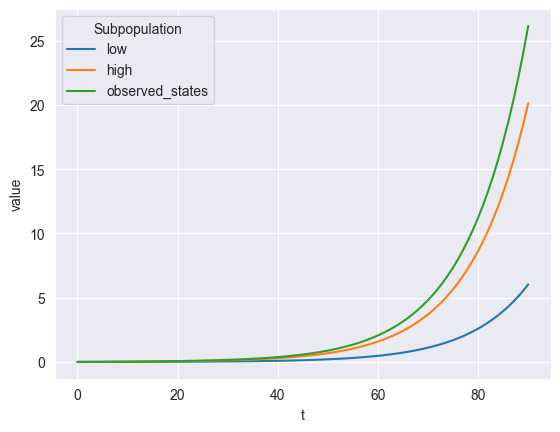

In [16]:
hospitalised_results = results_1_melted[results_1_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

In [17]:
# Total Hospitalised
display({'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')])})

{'Total hospitalisations': 87.89145481017233,
 'Peak hospitalisations': 26.15687669462622}

# 2.
## 2.1 Set up Seeders

In [18]:
from metacast import MultnomialSeeder

In [19]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

In [20]:
prevelance = 0.1
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'E': 26655, 'I': 63062, 'H': 283}

In [21]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'E': 2762, 'I': 6277, 'H': 961}

In [22]:
y =np.zeros(metapop_model.num_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [23]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

### 2.3 Run metapopulation model

In [24]:
results_2 = metapop_model.integrate(y,t)

In [25]:
results_2

low                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   794032.457332  32676.313346  63957.663269  313.750061    9019.815992   
2   777950.107544  37096.680089  66327.048240  341.151315   18285.012812   
3   761491.029955  40588.698577  69593.747479  367.300536   27959.223453   
4   744524.668972  43524.208597  73414.831722  393.338589   38142.952120   
..            ...           ...           ...         ...            ...   
86  156864.620524    535.185068   2737.599077   31.692935  739830.902397   
87  156733.510341    494.731038   2532.887573   29.353928  740209.517119   
88  156612.305201    457.339510   2343.355145   27.184133  740559.816012   
89  156500.255982    422.778024   2167.894953   25.171781  740883.899261   
90  156396.670333    390.831847   2005.478148   23.305856  741183.713816   

            high                                                       \
               S            E            I            H             R   
0   90000.000000  2762.000000  6277.000000   961.000000      0.000000   
1   88225.828592  3487.634064  6421.148879  1032.801942    832.586522   
2   86438.900838  4019.341059  6737.994908  1100.940429   1702.822767   
3   84610.114439  4436.402136  7158.080022  1171.276980   2624.126422   
4   82724.963219  4783.391616  7639.805351  1246.521660   3605.318154   
..           ...          ...          ...          ...           ...   
86  17429.402280    59.465008   304.172692   105.639410  82101.320610   
87  17414.834482    54.970115   281.427633    97.843213  82150.924557   
88  17401.367245    50.815501   260.369049    90.610989  82196.837216   
89  17388.917331    46.975336   240.873971    83.903518  82239.329844   
90  17377.407815    43.425761   222.828091    77.684090  82278.654243   

   observed_states                
                 H  H_cumulative  
0      1244.000000      0.000000  
1      1346.552003    361.822200  
2      1442.091744    736.260600  
3      1538.577516   1130.756261  
4      1639.860249   1549.784851  
..             ...           ...  
86      137.332345  31769.583959  
87      127.197141  31785.889041  
88      117.795122  31800.974463  
89      109.075299  31814.930719  
90      100.989946  31827.841697  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

In [26]:
results_2['t'] = t
results_2_melted = results_2.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_2_melted

,t,Subpopulation,State,value
0,0,low,S,810000.000000
1,1,low,S,794032.457332
2,2,low,S,777950.107544
3,3,low,S,761491.029955
4,4,low,S,744524.668972
...,...,...,...,...
1087,86,observed_states,H_cumulative,31769.583959
1088,87,observed_states,H_cumulative,31785.889041
1089,88,observed_states,H_cumulative,31800.974463
1090,89,observed_states,H_cumulative,31814.930719


<Axes: xlabel='t', ylabel='value'>

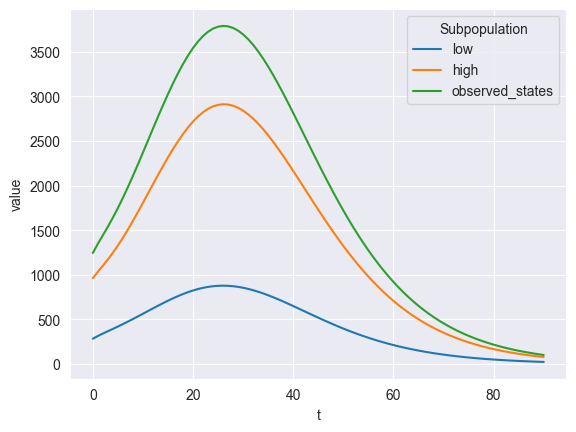

In [27]:
hospitalised_results = results_2_melted[results_2_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

In [28]:
display({'Total hospitalisations': results_2.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_2.loc[:,('observed_states','H')])})

{'Total hospitalisations': 31827.841696731277,
 'Peak hospitalisations': 3788.607630940858}

# 3. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.

## 3.1 Set metapopulation structure using a list of subpopulation transfer dictionaries for a scaffold.

In [29]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': ['S'], 'parameter': 'nu_0'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_1'}
                            for risk_group in risk_groups]

vaccination_scaffold = vaccination_transfers + vacination_lag_transfers
vaccination_scaffold

[{'from_coordinates': ('low', 'unvaccinated'),
  'to_coordinates': ('low', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('high', 'unvaccinated'),
  'to_coordinates': ('high', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('low', 'vaccination_lag'),
  'to_coordinates': ('low', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'},
 {'from_coordinates': ('high', 'vaccination_lag'),
  'to_coordinates': ('high', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'}]

In [30]:
metapop_model.set_structure(vaccination_scaffold)
metapop_model.subpops

[{'high', 'low'}, {'unvaccinated', 'vaccinated', 'vaccination_lag'}]

## 3.2 Set population

In [31]:
metapop_model.num_states

32

In [32]:
y = np.zeros(metapop_model.num_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

## 3.3 Set parameters

In [33]:
metapop_model.parameter_names

['beta_[high,unvaccinated]',
 'beta_[high,vaccinated]',
 'beta_[high,vaccination_lag]',
 'beta_[low,unvaccinated]',
 'beta_[low,vaccinated]',
 'beta_[low,vaccination_lag]',
 'eta',
 'gamma',
 'nu_0',
 'nu_1',
 'p_[high,unvaccinated]',
 'p_[high,vaccinated]',
 'p_[high,vaccination_lag]',
 'p_[low,unvaccinated]',
 'p_[low,vaccinated]',
 'p_[low,vaccination_lag]',
 'rho_[high,unvaccinated]_[high,unvaccinated]',
 'rho_[high,unvaccinated]_[high,vaccinated]',
 'rho_[high,unvaccinated]_[high,vaccination_lag]',
 'rho_[high,unvaccinated]_[low,unvaccinated]',
 'rho_[high,unvaccinated]_[low,vaccinated]',
 'rho_[high,unvaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccinated]_[high,unvaccinated]',
 'rho_[high,vaccinated]_[high,vaccinated]',
 'rho_[high,vaccinated]_[high,vaccination_lag]',
 'rho_[high,vaccinated]_[low,unvaccinated]',
 'rho_[high,vaccinated]_[low,vaccinated]',
 'rho_[high,vaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccination_lag]_[high,unvaccinated]',
 'rho_[high,vaccination

In [34]:
vaccination_rates = {'nu_0': 10000/7,
                     'nu_1': 1/14}
vaccine_reduced_susceptibility = 0.5
beta_parameters = {'beta_[high,unvaccinated]': transmission_no_intervention,
                   'beta_[high,vaccinated]': transmission_no_intervention*(1-vaccine_reduced_susceptibility),
                   'beta_[high,vaccination_lag]': transmission_no_intervention,
                   'beta_[low,unvaccinated]': transmission_no_intervention,
                   'beta_[low,vaccinated]': transmission_no_intervention*(1-vaccine_reduced_susceptibility),
                   'beta_[low,vaccination_lag]': transmission_no_intervention,}

vaccine_reduced_severity = 0.8
vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-vaccine_reduced_severity)/(1-vaccine_reduced_susceptibility))
hospitalisation_probs = {'p_[high,unvaccinated]': hig_risk_prob_of_hospital,
                         'p_[high,vaccinated]': hig_risk_prob_of_hospital*vaccine_reduced_severity_given_reduced_susceptibility,
                         'p_[high,vaccination_lag]': hig_risk_prob_of_hospital,
                         'p_[low,unvaccinated]': low_risk_prob_of_hospital,
                         'p_[low,vaccinated]': low_risk_prob_of_hospital*vaccine_reduced_severity_given_reduced_susceptibility,
                         'p_[low,vaccination_lag]': low_risk_prob_of_hospital}
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: subpopulation_interactions
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}

parameters = {**vaccination_rates,
              **non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

### 3.4 Run metapopulation model

In [35]:
results_3 = metapop_model.integrate(y,t)

In [36]:
results_3

low,vaccination_lag                                                      \
                     S             E             I          H            R   
0             0.000000      0.000000      0.000000   0.000000     0.000000   
1        739332.698008  12632.777426   2117.750463   0.997202   103.878947   
2        674443.494341  20271.684649   6783.735242   6.301770   691.254709   
3        614736.577190  24767.078444  12317.985196  16.878172  1950.478917   
4        559767.831122  27236.971269  17797.400064  31.897020  3884.502266   
..                 ...           ...           ...        ...          ...   
86          580.533572      1.578814      6.710134   0.070555  1151.677968   
87          540.130515      1.378141      5.857713   0.061609  1073.152936   
88          502.561355      1.202989      5.113552   0.053795   999.930879   
89          467.624550      1.050112      4.463910   0.046971   931.660236   
90          435.133238      0.916673      3.896790   0.041012   868.011904   

   low,vaccinated                                                      ...  \
                S            E            I          H              R  ...   
0        0.000000     0.000000     0.000000   0.000000       0.000000  ...   
1    54978.430716   686.324593   129.160795   0.045621       6.703478  ...   
2   104616.897431  2234.538737   848.320498   0.591247      91.948625  ...   
3   149273.908002  4154.640435  2367.735649   2.434376     401.050868  ...   
4   189304.802523  6187.305816  4674.100864   6.285158    1097.671146  ...   
..            ...          ...          ...        ...            ...  ...   
86  401334.715324   545.050353  2295.659532  14.414408  404058.356589  ...   
87  401232.615674   511.268296  2154.348860  13.531914  404456.421591  ...   
88  401136.544419   479.570609  2021.638295  12.702555  404829.448800  ...   
89  401046.152465   449.829883  1897.016683  11.923241  405178.999197  ...   
90  400961.110189   421.926345  1780.001710  11.191050  405506.538337  ...   

   high,vaccinated                          high,unvaccinated                \
                 I          H             R                 S             E   
0         0.000000   0.000000      0.000000      9.000000e+04  2.762000e+03   
1        14.351199   0.152069      0.597831     -1.436314e-10  1.979954e+03   
2        94.257833   1.970823      8.311385     -8.374530e-13  1.418699e+03   
3       263.081739   8.114588     36.717106      4.892413e-10  1.016542e+03   
4       519.344540  20.950527    101.711285     -8.067275e-10  7.283844e+02   
..             ...        ...           ...               ...           ...   
86      255.073281  48.048027  44848.926528    -3.956696e-118  9.810398e-10   
87      239.372096  45.106381  44895.999564    -7.805147e-118  7.029478e-10   
88      224.626477  42.341850  44940.119412    -2.505778e-120  5.036855e-10   
89      210.779631  39.744138  44981.469466    -9.869223e-122  3.609075e-10   
90      197.777968  37.303499  45020.221988    -3.234278e-123  2.586022e-10   

                                           observed_states                
              I            H             R               H  H_cumulative  
0   6277.000000   961.000000      0.000000     1244.000000      0.000000  
1   6168.421019  1029.231912    823.641173     1346.429863    361.695022  
2   5868.206680  1076.705228   1637.637155     1440.455720    734.485597  
3   5460.287659  1101.529755   2422.888401     1531.593832   1122.857679  
4   5000.861606  1104.829572   3167.172540     1621.116640   1527.680379  
..          ...          ...           ...             ...           ...  
86     0.051310     0.038180  10001.158594       62.818918  16058.694020  
87     0.044479     0.033112  10001.170492       58.949277  16066.997141  
88     0.038558     0.028716  10001.180809       55.315685  16074.786233  
89     0.033425     0.024903  10001.189755       51.904021  16082.092953  
90     0.028976     0.021596  10001.197512   

### 3.5 Plotting hospitalisations

In [37]:
results_3['t'] = t
results_3_melted = results_3.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_3_melted

,t,Subpopulation,State,value
0,0,"low,vaccination_lag",S,0.000000
1,1,"low,vaccination_lag",S,739332.698008
2,2,"low,vaccination_lag",S,674443.494341
3,3,"low,vaccination_lag",S,614736.577190
4,4,"low,vaccination_lag",S,559767.831122
...,...,...,...,...
2907,86,observed_states,H_cumulative,16058.694020
2908,87,observed_states,H_cumulative,16066.997141
2909,88,observed_states,H_cumulative,16074.786233
2910,89,observed_states,H_cumulative,16082.092953


<Axes: xlabel='t', ylabel='value'>

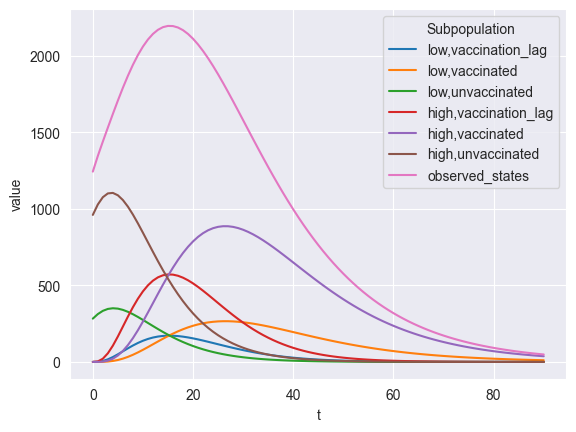

In [38]:
hospitalised_results = results_3_melted[results_3_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

In [39]:
display({'Total hospitalisations': results_3.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_3.loc[:,('observed_states','H')])})

{'Total hospitalisations': 16088.947031722832,
 'Peak hospitalisations': 2196.431988810305}